# Feature extraction code 

In [10]:
pip install scikit-image


  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/f3/93/65601f7577d6fd49ec23bf8fb58c04d8170b06a1544452ae2ea9f59bf11f/scikit_image-0.21.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/c7/b0/7b6c35b8636ed773325cdb6f5ac3cd36afba63d99e20ed59c521cf5018b4/imageio-2.31.1-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/74/68/19989a1009f68ed777ea5d2624c2996bab0890a31ce7d4b2a7ae4e1c0cfe/tifffile-2023.8.12-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
     - -------------------------------------- 0.2/4.2 MB 3.5 MB/s eta 0:00:02
     -- ------------------------------------- 0.3/4.2 MB 2.3 MB/s eta 0:00:02
     -- ------------------------------------- 0.3/4.2 MB 2.0 

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\RIYA DHAWAS\\AppData\\Local\\Temp\\pip-build-tracker-tnzllztv\\4248ff41b2c7b54a238581e2db2d88702f93dfb7affdd93cd3b3f7d8'



In [2]:
pip show scikit-image


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras 
from skimage.feature import graycomatrix, graycoprops

def preprocess_image(image):
    image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # Resize the image
    image = cv2.resize(image, (256, 256)) 
    return image
    

# Set the feature extraction function
def extract_features(image): 
    l=[]
    # Load pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    model.eval()

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image to a tensor
    image_tensor = torch.from_numpy(image_rgb.transpose((2, 0, 1))).float()

    # Run the image through the model
    output = model([image_tensor])

    # Retrieve the predicted bounding boxes
    boxes = output[0]['boxes'].detach().numpy()

    # Step 2: Shadow Removal and Enhancing Banana Regions

    # Convert the image to the LAB color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # Split the LAB image into channels
    l_channel, a_channel, b_channel = cv2.split(image_lab)

    # Apply adaptive thresholding to the L channel to obtain a binary mask of shadows
    _, shadow_mask = cv2.threshold(l_channel, 50, 255, cv2.THRESH_BINARY)

    # Invert the shadow mask
    shadow_mask_inv = cv2.bitwise_not(shadow_mask)

    # Apply the shadow mask to the L channel to reduce shadow effects
    l_channel_no_shadow = cv2.bitwise_and(l_channel, shadow_mask_inv)

    # Combine the modified L channel with the original A and B channels
    image_lab_no_shadow = cv2.merge([l_channel_no_shadow, a_channel, b_channel])

    # Convert the modified LAB image back to the BGR color space
    image_no_shadow = cv2.cvtColor(image_lab_no_shadow, cv2.COLOR_LAB2BGR)

    # Step 3: Segment Banana Bunches using K-means Clustering

    # Convert the image without shadow to the LAB color space
    image_no_shadow_lab = cv2.cvtColor(image_no_shadow, cv2.COLOR_BGR2LAB)

    # Extract the L channel
    l_channel_no_shadow = cv2.split(image_no_shadow_lab)[0]

    # Reshape the L channel to a 2D array of pixels
    pixels = l_channel_no_shadow.reshape(-1, 1)

    # Convert the pixel values to floating point
    pixels = np.float32(pixels)

    # Perform K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    k = 2
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Reshape the labels to match the original image shape
    segmented = labels.reshape(image.shape[:2])

    # Create a mask for the banana region
    mask = np.uint8(segmented == 1) * 255

    # Apply the mask to the original image
    segmented_image = cv2.bitwise_and(image, image, mask=mask)

    # Step 4: Extract Shape-based Features

    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate through each contour and extract shape-based features
    for contour in contours:
        # Compute contour properties
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        # Calculate bounding rectangle
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate aspect ratio
        aspect_ratio = float(w) / h

        # Calculate convex hull
        hull = cv2.convexHull(contour)

        # Calculate solidity if hull area is non-zero
        hull_area = cv2.contourArea(hull)
        if hull_area > 0:
            solidity = area / hull_area
        else:
            solidity = 0  
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_uint8 = gray.astype(np.uint8)  # Convert to unsigned integer type
    
    # Compute the GLCM
    distances = [1]  # Distance between pixels (you can experiment with different values)
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles for texture measurements
    glcm = graycomatrix(gray_uint8, distances, angles, levels=256, symmetric=True, normed=True)
    
    # Extract texture features
    contrast = graycoprops(glcm, prop='contrast').ravel()
    dissimilarity = graycoprops(glcm, prop='dissimilarity').ravel()
    homogeneity = graycoprops(glcm, prop='homogeneity').ravel()
    energy = graycoprops(glcm, prop='energy').ravel()
    correlation = graycoprops(glcm, prop='correlation').ravel() 
    color_contrast = np.max(image) - np.min(image)
    red_channel = image[:,:,0]
    green_channel = image[:,:,1]
    blue_channel = image[:,:,2]
    blue_channel[blue_channel == 255] = 0
    green_channel[green_channel == 255] = 0
    red_channel[red_channel == 255] = 0

    red_mean = np.mean(red_channel)
    green_mean = np.mean(green_channel)
    blue_mean = np.mean(blue_channel)

    red_std = np.std(red_channel)
    green_std = np.std(green_channel)
    blue_std = np.std(blue_channel)
    x = pd.Series(dtype=float)
    x['Area'] = area
    x['Perimeter'] = perimeter
    x['Aspect Ratio'] = aspect_ratio
    x['Solidity'] = solidity
    x['Contrast'] = contrast
    x['Dissimilarity'] = dissimilarity
    x['Homogeneity'] = homogeneity
    x['Energy'] = energy
    x['Correlation'] = correlation
    x['Red Mean'] = red_mean
    x['Blue Mean'] = blue_mean
    x['Green Mean'] = green_mean
    x['Red Std'] = red_std
    x['Green Std'] = green_std
    x['Blue Std'] = blue_std
    x['Color Contrast'] = color_contrast
    return x 

ModuleNotFoundError: No module named 'skimage'

# Creation of Resnet50 feat

In [2]:
import csv
from torchvision.models import resnet50
import pandas as pd 
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [3]:
# i=0
# # Create ResNet50 model
# resnet_model = resnet50(pretrained=True)

# # Open the CSV file in write mode
# with open(csv_file, 'w', newline='') as file:
#     writer = csv.writer(file)
    
#     # Get the number of ResNet50 features
#     resnet_feature_count = resnet_model.fc.out_features

#     # Create the header row
#     header_row = ['Image', 'Class']  # Add 'Class' column to the header row
#     header_row += [f'ResNet50_Feature{i+1}' for i in range(resnet_feature_count)]
#     # Manually add the custom feature names to the header row
#     header_row += ['Area', 'Perimeter','Aspect Ratio','Solidity','Contrast','Dissimilarity','Homogeneity','Energy','Correlation','Red Mean','Blue Mean','Green Mean','Red Std','Green Std','Blue Std','Color Contrast']  # Add your custom feature names here

#     # Write the header row
#     writer.writerow(header_row)
    
#     # Iterate through each folder (class) in the main folder
#     for class_folder in os.listdir(main_folder):
#         class_folder_path = os.path.join(main_folder, class_folder)

#         # Iterate through each image file in the class folder
#         for image_file in os.listdir(class_folder_path):
#             image_path = os.path.join(class_folder_path, image_file)

#             # Load and preprocess the image
#             image = cv2.imread(image_path)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
#             # Resize the image to the desired input size of the ResNet model
#             image = cv2.resize(image, (224, 224))

#             # Convert the image to a PyTorch tensor
#             image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
            
#             # Normalize the image tensor
#             image_tensor = image_tensor / 255.0
#             normalize = torch.tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
#             std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
#             image_tensor = (image_tensor - normalize) / std

#             # Extract features using ResNet50
#             with torch.no_grad():
#                 resnet_features = resnet_model(image_tensor)
#                 resnet_features = resnet_features.squeeze().numpy()

#             # Extract custom features using your code
#             custom_features = extract_features(image)  # Use the modified feature extraction code

#             # Convert the features to a list
#             class_name = class_folder  # Get the class name from the subfolder
#             features_list = [image_file, class_name] + resnet_features.tolist() + [custom_features['Area'], custom_features['Perimeter'],custom_features['Aspect Ratio'],custom_features['Solidity'],custom_features['Contrast'],custom_features['Dissimilarity'],custom_features['Homogeneity'],custom_features['Energy'],custom_features['Correlation'],custom_features['Red Mean'],custom_features['Blue Mean'],custom_features['Green Mean'],custom_features['Red Std'],custom_features['Green Std'],custom_features['Blue Std'],custom_features['Color Contrast']]  # Add your custom feature values here

#             # Write the features to the CSV file
#             writer.writerow(features_list)
#             i+=1
#             print(i,end=" ")

# print("CSV file created successfully.")


In [5]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [6]:
# Set the main folder path
main_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (2)"

# Define the output CSV file path
csv_file = r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\main_features_2.csv'

In [5]:
# import os
# os.getcwd()
# import shutil
# shutil.move("fruit_shelf_life_csv_preprocessing.ipynb", "Fruit_shelf_life/fruit_shelf_life_csv_preprocessing.ipynb")

# Pipeline on resnet50 + own feat + small DL classifier

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer

# Load the CSV data into a DataFrame
data = pd.read_csv( r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\main_features_2.csv')

# Drop the 'image_file' column
data.drop('Image', axis=1, inplace=True)

# Split the data into features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Encode the target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
for i in X.columns:
    X[i]=pd.to_numeric(X[i],errors='coerce')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create an instance of the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Apply the imputer to fill missing values
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
pipelines = {
    'Decision Tree': Pipeline([('clf', DecisionTreeClassifier())]),
    'Random Forest': Pipeline([('clf', RandomForestClassifier())]),
    'SVM': Pipeline([('clf', SVC())]),
    'XGBoost': Pipeline([('clf', XGBClassifier())]),
    'Multi-Layer Perceptron': Pipeline([('clf', MLPClassifier())])
}
results = {}

for name, pipeline in pipelines.items():
    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

    # Store the results
    results[name] = {
        'Accuracy': accuracy,
        'Classification Report': report
    }
for name, result in results.items():
    print(f"--- {name} ---")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Classification Report:")
    print(pd.DataFrame(result['Classification Report']).transpose())
    print()

ModuleNotFoundError: No module named 'xgboost'

In [1]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/75/dd/9afe0d9d0f61a5384c3932626a022e38c396a5d88e6f5345ad2f7b576747/xgboost-1.7.6-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/70.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/70.9 MB 660.6 kB/s eta 0:01:48
   ---------------------------------------- 0.0/70.9 MB 660.6 kB/s eta 0:01:48
   ---------------------------------------- 0.1/70.9 MB 438.9 kB/s eta 0:02:42
   ---------------------------------------- 0.1/70.9 MB 525.1 kB/s eta 0:02:15
   ---------------------------------------- 0.2/70.9 MB 751.6 kB/s eta 0:01:35
   ---------------------------------------- 0.3/70.9 MB 947.5 kB/s eta 0:01:15
   ---------------------------------------- 0.4/70.9 MB 1.2 MB/s eta 0:01:00
   ---------------------------------------- 0.5/70.9 MB 1.5 MB/s eta 0:00:49
   ------------------------

In [13]:
# import os
# import matplotlib.pyplot as plt

# # Path to the folder containing test images
# test_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\new_test_images"

# # Iterate through each image file in the test folder
# for image_file in os.listdir(test_folder):
#     image_path = os.path.join(test_folder, image_file)

#     # Load and preprocess the image
#     image = cv2.imread(image_path) 
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Resize the image to the desired input size of the ResNet model
#     image = cv2.resize(image, (224, 224))
#     # Create ResNet50 model
#     resnet_model = resnet50(pretrained=True) 
#     resnet_feature_count = resnet_model.fc.out_features
#     # header row
#     header_row = ['Image']
#     header_row += [f'ResNet50_Feature{i+1}' for i in range(resnet_feature_count)]
#     # Manually add the custom feature names to the header row
#     header_row += ['Area', 'Perimeter','Aspect Ratio','Solidity','Contrast','Dissimilarity','Homogeneity','Energy','Correlation','Red Mean','Blue Mean','Green Mean','Red Std','Green Std','Blue Std','Color Contrast']  # Add your custom feature names here

#     # Convert the image to a PyTorch tensor
#     image_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
#     # Normalize the image tensor
#     image_tensor = image_tensor / 255.0
#     normalize = torch.tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
#     std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
#     image_tensor = (image_tensor - normalize) / std

#     # Extract features using ResNet50
#     with torch.no_grad():
#         resnet_features = resnet_model(image_tensor)
#         resnet_features = resnet_features.squeeze().numpy()

#     # Extract custom features using your code
#     custom_features = extract_features(image)  # Use the modified feature extraction code

#     # Convert the features to a list
#     features_list = [image_file] + resnet_features.tolist() + [custom_features['Area'], custom_features['Perimeter'],custom_features['Aspect Ratio'],custom_features['Solidity'],custom_features['Contrast'],custom_features['Dissimilarity'],custom_features['Homogeneity'],custom_features['Energy'],custom_features['Correlation'],custom_features['Red Mean'],custom_features['Blue Mean'],custom_features['Green Mean'],custom_features['Red Std'],custom_features['Green Std'],custom_features['Blue Std'],custom_features['Color Contrast']]  # Add your custom feature values here
#     # Create a DataFrame from features_list
#     feat = pd.DataFrame([features_list], columns=header_row)
#     # Access the data in the DataFrame
#     feat.head()

#     dfs=[]
#     for i in feat['Correlation']:
#         lst = str(i).strip('[]').split()
#         df = pd.DataFrame([list(map(float, lst))], columns=['Correlation1', 'Correlation2', 'Correlation3', 'Correlation4'])
#         dfs.append(df)
#     df_Correlation = pd.concat(dfs, ignore_index=True)
#     dfs=[]
#     for i in feat['Contrast']:
#         lst = str(i).strip('[]').split()
#         df = pd.DataFrame([list(map(float, lst))], columns=['Contrast1', 'Contrast2', 'Contrast3', 'Contrast4'])
#         dfs.append(df)
#     df_Contrast = pd.concat(dfs, ignore_index=True)
#     dfs=[]
#     for i in feat['Energy']:
#         lst = str(i).strip('[]').split()
#         df = pd.DataFrame([list(map(float, lst))], columns=['Energy1', 'Energy2', 'Energy3', 'Energy4'])
#         dfs.append(df)
#     df_Energy = pd.concat(dfs, ignore_index=True)
#     dfs=[]
#     for i in feat['Dissimilarity']:
#         lst = str(i).strip('[]').split()
#         df = pd.DataFrame([list(map(float, lst))], columns=['Dissimilarity1', 'Dissimilarity2', 'Dissimilarity3', 'Dissimilarity4'])
#         dfs.append(df)
#     df_Dissimilarity = pd.concat(dfs, ignore_index=True)
#     dfs=[]
#     for i in feat['Homogeneity']:
#         lst = str(i).strip('[]').split()
#         df = pd.DataFrame([list(map(float, lst))], columns=['Homogeneity1', 'Homogeneity2', 'Homogeneity3', 'Homogeneity4'])
#         dfs.append(df)
#     df_Homogeneity = pd.concat(dfs, ignore_index=True)

#     data=pd.concat([feat,df_Contrast,df_Dissimilarity,df_Homogeneity,df_Energy,df_Correlation],axis=1)
#     data.drop(columns=['Homogeneity','Correlation','Energy','Contrast','Dissimilarity'],inplace=True,axis=1)
#     for name, pipeline in pipelines.items():
#         # Extract features from the image
#         image_features = extract_features(image)

#         # Prepare the features for prediction
#         features_array = np.array([list(image_features.values())])
#         features_scaled = scaler.transform(features_array)
#         features_reshaped = features_scaled.reshape(features_scaled.shape[0], -1)

#         # Make prediction
#         predicted_class = pipeline.predict(features_reshaped)
#         predicted_label = label_encoder.inverse_transform(predicted_class)[0]

#         # Display the image, predicted class, and algorithm
#         plt.imshow(image)
#         plt.title(f"Predicted Class: {predicted_label} \nAlgorithm: {name}")
#         plt.axis('off')
#         plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)

# Create an instance of the KNN imputer
imputer = KNNImputer(n_neighbors=5)

# Apply the imputer to fill missing values
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test) 

# Scale the input features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the target variable to categorical (one-hot) encoding
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Create a neural network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=28, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print("Accuracy:", accuracy)

NameError: name 'X' is not defined

In [16]:
dat=pd.read_csv(r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\main_features_2.csv")
dat.head()

,Class,Image,ResNet50_Feature1,ResNet50_Feature2,ResNet50_Feature3,ResNet50_Feature4,ResNet50_Feature5,ResNet50_Feature6,ResNet50_Feature7,ResNet50_Feature8,...,Homogeneity3,Homogeneity4,Energy1,Energy2,Energy3,Energy4,Correlation1,Correlation2,Correlation3,Correlation4
0,Apple(1-5),frame1000.jpg,0.461865,1.016772,1.457841,1.102882,1.734266,1.521513,0.604329,-2.078014,...,-0.904259,-0.695889,-0.647021,-0.647296,-0.681720,-0.645982,0.928792,1.026544,0.915602,1.002110
1,Apple(1-5),frame1010.jpg,-0.408371,0.488601,1.633036,0.876208,2.023478,2.118292,0.922432,-1.888090,...,-0.891765,-0.684029,-0.647010,-0.647193,-0.682404,-0.646955,0.928767,1.026288,0.914997,1.001687
2,Apple(1-5),frame1020.jpg,-0.145309,0.688797,0.846686,0.990922,1.566360,1.531195,0.775125,-0.873324,...,-0.882431,-0.693034,-0.648845,-0.649114,-0.683508,-0.649215,0.929158,1.026833,0.916967,1.003360
3,Apple(1-5),frame1030.jpg,-0.548450,0.339534,1.961191,1.538531,2.778398,2.779662,1.255512,0.003496,...,-0.838838,-0.669371,-0.637250,-0.639394,-0.674133,-0.637685,0.926855,1.024126,0.912604,0.998968
4,Apple(1-5),frame1040.jpg,-0.509837,-0.211997,2.517604,1.718995,2.179305,1.264437,1.881916,-0.675665,...,-0.821919,-0.647103,-0.636860,-0.642785,-0.678106,-0.642210,0.927331,1.024718,0.913599,0.999710


# Creation of Imagenet Features Features 

In [17]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input

In [18]:
# Define the path to the main folder containing the image subfolders
main_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (2)"

# Define the path to the CSV file containing the extracted features
csv_file = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\main_features_2.csv"

# Load the MobileNet model
model_img = MobileNet(weights='imagenet', include_top=False, pooling='avg')

# Load and process the CSV features
csv_features = []
with open(csv_file, 'r') as file:
    csv_reader = csv.reader(file)
    header=next(csv_reader)
    class_label_index = header.index('Class')
    image_column_index = header.index('Image')
    for row in csv_reader:
        features = [float(feature) for index, feature in enumerate(row) if index not in [class_label_index, image_column_index]]
        csv_features.append(features)
        #csv_features.append([float(feature) for feature in row[1:]])

csv_features = np.array(csv_features)

# Initialize the lists to store image features and labels
image_features = []
labels = []

# Iterate through the subfolders in the main folder
for subfolder in os.listdir(main_folder):
    subfolder_path = os.path.join(main_folder, subfolder)
    
    # Iterate through the images in each subfolder
    for image_file in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_file)
        
        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)
        
        # Extract image features using MobileNet
        img_features = model_img.predict(np.expand_dims(img, axis=0))
        img_features = img_features.flatten()
        
        # Combine image features with CSV features
        combined_features = np.concatenate((img_features, csv_features[len(labels)]))
        
        # Add combined features and label to the respective lists
        image_features.append(combined_features)
        labels.append(subfolder)  # Assuming the subfolder names represent class labels

# Convert the lists to numpy arrays
image_features = np.array(image_features)
labels = np.array(labels)

# Perform classification using your preferred classifier or deep learning model
# Split the data into training and testing sets, and train your model accordingly
# Evaluate the model and make predictions on new data as needed


1/1 [==============================] - 0s 109ms/step


In [19]:
image_features.shape

(1932, 2055)

# Simple Logisitc Regression on Imagenet + Resnet + own feat

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_features, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# Train a logistic regression classifier
classifier = LogisticRegression(penalty='l2',max_iter=1000)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.917312661498708


C:\Users\RIYA DHAWAS\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# DL Network on ImageNet + Resnet50 + own feat

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Convert labels to integer format
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to one-hot encoded format
num_classes = len(set(labels_encoded))
labels_encoded = to_categorical(labels_encoded, num_classes=num_classes)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_features, labels_encoded, test_size=0.2, random_state=42)

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


# Define the model architecture
model_seq = Sequential()
model_seq.add(Dense(256, activation='relu', input_shape=(image_features.shape[1],)))
model_seq.add(Dense(128, activation='relu'))
model_seq.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_seq.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test set
y_pred = model_seq.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded predictions to labels
y_test_labels = np.argmax(y_test, axis=1)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_labels, y_pred_classes)
print("Accuracy:", accuracy)


Epoch 1/50
49/49 [==============================] - 2s 30ms/step - loss: 0.6967 - accuracy: 0.7709 - val_loss: 0.3376 - val_accuracy: 0.8760
Epoch 2/50
49/49 [==============================] - 1s 26ms/step - loss: 0.2551 - accuracy: 0.9068 - val_loss: 0.4483 - val_accuracy: 0.8734
Epoch 3/50
49/49 [==============================] - 1s 26ms/step - loss: 0.1974 - accuracy: 0.9320 - val_loss: 0.3334 - val_accuracy: 0.9121
Epoch 4/50
49/49 [==============================] - 1s 26ms/step - loss: 0.1888 - accuracy: 0.9450 - val_loss: 0.2994 - val_accuracy: 0.9225
Epoch 5/50
49/49 [==============================] - 1s 26ms/step - loss: 0.1178 - accuracy: 0.9605 - val_loss: 0.2599 - val_accuracy: 0.9354
Epoch 6/50
49/49 [==============================] - 1s 26ms/step - loss: 0.1099 - accuracy: 0.9638 - val_loss: 0.2666 - val_accuracy: 0.9096
Epoch 7/50
49/49 [==============================] - 1s 26ms/step - loss: 0.1089 - accuracy: 0.9573 - val_loss: 0.2747 - val_accuracy: 0.9199
Epoch 8/50
49

In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.utils import to_categorical
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder

# # Convert labels to integer format
# label_encoder = LabelEncoder()
# labels_encoded = label_encoder.fit_transform(labels)

# # Convert labels to one-hot encoded format
# num_classes = len(set(labels_encoded))
# labels_encoded = to_categorical(labels_encoded, num_classes=num_classes)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(image_features, labels_encoded, test_size=0.2, random_state=42)

# # Initialize the scaler
# scaler = StandardScaler()

# # Scale the training and testing features
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Initialize the PCA model
# pca = PCA(n_components=0.95)  # Retain 95% of the variance
# # Fit and transform the scaled training features
# X_train_pca = pca.fit_transform(X_train_scaled)
# # Transform the scaled testing features
# X_test_pca = pca.transform(X_test_scaled)


# # Define the model architecture
# model_seq = Sequential()
# model_seq.add(Dense(256, activation='relu', input_shape=(X_train_pca.shape[1],)))  # Update the input shape
# model_seq.add(Dense(128, activation='relu'))
# model_seq.add(Dense(num_classes, activation='softmax'))

# # Compile the model
# model_seq.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
# model_seq.fit(X_train_pca, y_train, epochs=50, batch_size=32, validation_data=(X_test_pca, y_test))

# # Make predictions on the test set
# y_pred = model_seq.predict(X_test_pca)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Convert one-hot encoded predictions to labels
# y_test_labels = np.argmax(y_test, axis=1)

# # Evaluate the accuracy of the model
# accuracy = accuracy_score(y_test_labels, y_pred_classes)
# print("Accuracy:", accuracy)


In [ ]:
model_seq.summary()

In [ ]:
print(y_train.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

# Imagenet model new image test

In [ ]:
# import numpy as np
# from tensorflow.keras.applications import MobileNet
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.mobilenet import preprocess_input

# # Load the MobileNet model
# model_img = MobileNet(weights='imagenet', include_top=False, pooling='avg')

# # Load and preprocess the image
# img = image.load_img(image_path, target_size=(224, 224))
# img = image.img_to_array(img)
# img = preprocess_input(img)

# # Extract image features using MobileNet
# img_features_test = model_img.predict(np.expand_dims(img, axis=0))
# img_features_test = img_features_test.flatten()

# # Combine image features with CSV features (assuming csv_features is defined)
# combined_features_test = np.concatenate((img_features_test, csv_features_test[index]))

# # Reshape the combined features to 2D array
# combined_features_test = combined_features_test.reshape(1, -1)


# # Scale the training and testing features

# combined_features_scaled = scaler.transform(combined_features_test)

# # Fit and transform the scaled training features
# combined_features_pca = pca.transform(combined_features_scaled)

# # Convert the combined features to a numpy array
# combined_features_test = np.array(combined_features_test)

In [ ]:
# from tensorflow.keras.preprocessing import image

# # Resize and preprocess the images
# def preprocess_images(images):
#     processed_images = []
#     for img in images:
#         img = image.smart_resize(img, (224, 224))
#         img = image.img_to_array(img)
#         img = preprocess_input(img)
#         processed_images.append(img)
#     return np.array(processed_images)

# # Preprocess the image features
# X_train_img = preprocess_images(X_train_img)
# X_test_img = preprocess_images(X_test_img)


In [23]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the path to the main folder containing the image subfolders
main_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (2)"

# Define the path to the CSV file containing the extracted features
csv_file = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\main_features_2.csv"


df=pd.read_csv(csv_file) 
# Load and process the CSV features
# df = pd.read_csv(csv_file, skiprows=1)
csv_features = df.iloc[:, 2:].values.astype(float)  # Exclude the class label and image name columns

# Load the MobileNetV2 model (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# Define the input layers for the image and CSV features
image_input = base_model.input
csv_input = Input(shape=(csv_features.shape[1],))

# Create separate dense layers for image and CSV features
image_dense = Dense(256, activation='relu')(base_model.output)
csv_dense = Dense(256, activation='relu')(csv_input)

# Concatenate the dense layers
combined_features = Concatenate()([image_dense, csv_dense])

# Add custom classification layers on top
x = Dense(256, activation='relu')(combined_features)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=[image_input, csv_input], outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Perform prediction on new data
# image_path = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\apple_1.jpg"  # Replace with the path to your new image
# img = image.load_img(image_path, target_size=(224, 224))
# img = image.img_to_array(img)
# img = preprocess_input(img)
# img_features = np.expand_dims(img, axis=0)

# # Combine image features with CSV features
# combined_features = [base_model.predict(img_features), csv_features]

# # Perform prediction
# prediction = model.predict(combined_features)

# # Convert prediction to class label
# predicted_class = np.argmax(prediction)

# # Print the predicted class label
# print("Predicted class:", predicted_class)


In [ ]:
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications import MobileNetV2
# from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# from tensorflow.keras.layers import Dense, Concatenate, Input
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import train_test_split

# # Define the path to the main folder containing the image subfolders
# main_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (2)"

# # Define the path to the CSV file containing the extracted features
# csv_file = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\main_features_2.csv"

# df = pd.read_csv(csv_file) 
# # Load and process the CSV features
# csv_features = df.iloc[:, 2:].values.astype(float)  # Exclude the class label and image name columns

# # Split the data into training and testing sets
# X_train_img, X_test_img, X_train_csv, X_test_csv, y_train, y_test = train_test_split(image_features, csv_features, labels_encoded, test_size=0.2, random_state=42)

# # Load the MobileNetV2 model (pre-trained on ImageNet)
# base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# # Define the input layers for the image and CSV features
# image_input = base_model.input
# csv_input = Input(shape=(csv_features.shape[1],))

# # Create separate dense layers for image and CSV features
# image_dense = Dense(256, activation='relu')(base_model.output)
# csv_dense = Dense(256, activation='relu')(csv_input)

# # Concatenate the dense layers
# combined_features = Concatenate()([image_dense, csv_dense])

# # Add custom classification layers on top
# x = Dense(256, activation='relu')(combined_features)
# predictions = Dense(num_classes, activation='softmax')(x)

# # Create the final model
# model = Model(inputs=[image_input, csv_input], outputs=predictions)

# # Compile the model
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit([X_train_img, X_train_csv], y_train, epochs=50, batch_size=32,validation_data=([X_test_img, X_test_csv], y_test))

# # Print the training and testing accuracy
# train_accuracy = history.history['accuracy']
# test_accuracy = history.history['val_accuracy']
# print("Training Accuracy:", train_accuracy)
# print("Testing Accuracy:", test_accuracy)


In [24]:
print("image_features.shape",image_features.shape)
print("csv_features.shape",csv_features.shape)
print("labels_encoded.shape",labels_encoded.shape)

image_features.shape (1932, 2055)
csv_features.shape (1932, 1031)
labels_encoded.shape (1932, 14)


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.utils import to_categorical

# # Load and process the CSV features
# # df = pd.read_csv(csv_file, skiprows=1)
# csv_features = df.iloc[:, 2:].values.astype(float)  # Exclude the class label and image name columns

# # Load the MobileNetV2 model (pre-trained on ImageNet)
# base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# # Define the input layers for the image and CSV features
# image_input = base_model.input
# csv_input = Input(shape=(csv_features.shape[1],))

# # Create separate dense layers for image and CSV features
# image_dense = Dense(256, activation='relu')(base_model.output)
# csv_dense = Dense(256, activation='relu')(csv_input)

# # Concatenate the dense layers
# combined_features = Concatenate()([image_dense, csv_dense])

# # Add custom classification layers on top
# x = Dense(256, activation='relu')(combined_features)
# predictions = Dense(num_classes, activation='softmax')(x)

# # Create the final model
# model = Model(inputs=[image_input, csv_input], outputs=predictions)

# # Compile the model
# model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split([image_features, csv_features], labels, test_size=0.2, random_state=42)

# # Convert labels to categorical format
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# # Train the model
# model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))

# # Evaluate the model on the testing data and print the accuracy
# loss, accuracy = model.evaluate(X_test, y_test)
# print(f"Accuracy: {accuracy}")

In [ ]:
# # Perform prediction on new data
# image_path = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\new_test_images\apple_1.jpg"  # Replace with the path to your new image
# img = image.load_img(image_path, target_size=(224, 224))
# img = image.img_to_array(img)
# img = preprocess_input(img)
# img_features = np.expand_dims(img, axis=0)

# # Repeat the image features to match the number of samples in the CSV features
# num_samples = csv_features.shape[0]
# img_features = np.repeat(img_features, num_samples, axis=0)

# # Combine image features with CSV features
# combined_features = [img_features, csv_features]

# # Perform prediction
# prediction = model.predict(combined_features)

# # Convert prediction to class label
# predicted_classes = np.argmax(prediction, axis=1)

# # Print the predicted class labels
# print("Predicted classes:", predicted_classes)
# predicted_labels = label_encoder.inverse_transform(predicted_classes)

# # Print the predicted labels
# print("Predicted labels:", predicted_labels)

In [25]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Define the path to the main folder containing the image subfolders
main_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (2)"

# Load the image data and labels
image_data = []
labels = []

# Iterate through each subfolder
for class_folder in os.listdir(main_folder):
    class_folder_path = os.path.join(main_folder, class_folder)
    if os.path.isdir(class_folder_path):
        # Load images from the subfolder
        for img_file in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, img_file)
            img = image.load_img(img_path, target_size=(224, 224))
            img = image.img_to_array(img)
            img = preprocess_input(img)
            image_data.append(img)
            labels.append(class_folder)

# Convert the image data and labels to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Perform one-hot encoding on the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels_encoded, test_size=0.2, random_state=42)

# Load the MobileNetV2 model (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a fully connected layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/10
49/49 [==============================] - 55s 1s/step - loss: 0.9416 - accuracy: 0.6615 - val_loss: 0.4901 - val_accuracy: 0.7700
Epoch 2/10
49/49 [==============================] - 49s 1s/step - loss: 0.3959 - accuracy: 0.8401 - val_loss: 0.3815 - val_accuracy: 0.8346
Epoch 3/10
49/49 [==============================] - 49s 995ms/step - loss: 0.2918 - accuracy: 0.8854 - val_loss: 0.3546 - val_accuracy: 0.8837
Epoch 4/10
49/49 [==============================] - 44s 896ms/step - loss: 0.2380 - accuracy: 0.9049 - val_loss: 0.3015 - val_accuracy: 0.8966
Epoch 5/10
49/49 [==============================] - 52s 1s/step - loss: 0.2475 - accuracy: 0.8990 - val_loss: 0.3680 - val_accuracy: 0.8501
Epoch 6/10
49/49 [==============================] - 57s 1s/step - loss: 0.2330 - accuracy: 0.8997 - val_loss: 0.3442 - val_accuracy: 0.9096
Epoch 7/10
49/49 [==============================] - 55s 1s/step - loss: 0.1883 - accuracy: 0.9236 - val_loss: 0.2292 - val_accuracy: 0.9070
Epoch 8/10
49/

In [30]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Define the path to the main folder containing the image subfolders
main_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (2)"

# Load the image data and labels
image_data = []
labels = []

# Iterate through each subfolder
for class_folder in os.listdir(main_folder):
    class_folder_path = os.path.join(main_folder, class_folder)
    if os.path.isdir(class_folder_path):
        # Load images from the subfolder
        for img_file in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, img_file)
            img = image.load_img(img_path, target_size=(224, 224))
            img = image.img_to_array(img)
            img = preprocess_input(img)
            image_data.append(img)
            labels.append(class_folder)

# Convert the image data and labels to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Perform one-hot encoding on the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels_encoded, test_size=0.2, random_state=42)

# Load the MobileNetV2 model (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a fully connected layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/40
49/49 [==============================] - 44s 846ms/step - loss: 0.8946 - accuracy: 0.6641 - val_loss: 0.4331 - val_accuracy: 0.8062
Epoch 2/40
49/49 [==============================] - 42s 862ms/step - loss: 0.3979 - accuracy: 0.8434 - val_loss: 0.3424 - val_accuracy: 0.8682
Epoch 3/40
49/49 [==============================] - 40s 827ms/step - loss: 0.2756 - accuracy: 0.8945 - val_loss: 0.3118 - val_accuracy: 0.8553
Epoch 4/40
49/49 [==============================] - 43s 873ms/step - loss: 0.2449 - accuracy: 0.9055 - val_loss: 0.3919 - val_accuracy: 0.8605
Epoch 5/40
49/49 [==============================] - 41s 845ms/step - loss: 0.2625 - accuracy: 0.8919 - val_loss: 0.2597 - val_accuracy: 0.9044
Epoch 6/40
49/49 [==============================] - 41s 843ms/step - loss: 0.2117 - accuracy: 0.9197 - val_loss: 0.2648 - val_accuracy: 0.8992
Epoch 7/40
49/49 [==============================] - 43s 886ms/step - loss: 0.2120 - accuracy: 0.9249 - val_loss: 0.3062 - val_accuracy: 0.8966

In [32]:
# Save the trained model
model.save(r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\object_detection\shelf_life.h5") 

# from tensorflow.keras.models import load_model

# loaded_model = load_model("trained_mobilenetv2_model.h5")

C:\Users\RIYA DHAWAS\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
!pip install --upgrade pip
!pip install --upgrade setuptools

  Obtaining dependency information for setuptools from https://files.pythonhosted.org/packages/b8/49/b3b29c52b09075fb77f69309763a563b4054d5808a3f3b95df3a62ef3d3f/setuptools-68.1.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/805.2 kB ? eta -:--:--
   --- ------------------------------------ 71.7/805.2 kB 2.0 MB/s eta 0:00:01
   --------------------- ------------------ 440.3/805.2 kB 5.5 MB/s eta 0:00:01
   ---------------------------------------  798.7/805.2 kB 5.6 MB/s eta 0:00:01
   ---------------------------------------- 805.2/805.2 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.0.0
    Uninstalling setuptools-68.0.0:
      Successfully uninstalled setuptools-68.0.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
conda-repo-cli 1.0.41 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.41 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.41 requires requests==2.28.1, but you have requests 2.29.0 which is incompatible.


In [28]:
# !pip install --user matplotlib --upgrade

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


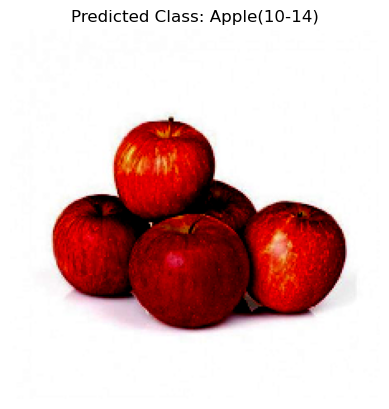

1/1 [==============================] - 0s 157ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


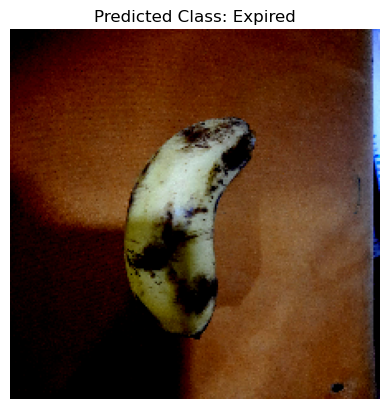

1/1 [==============================] - 0s 165ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


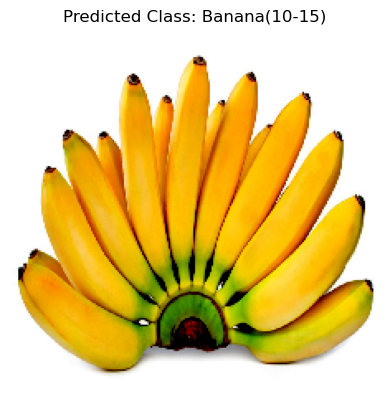

1/1 [==============================] - 0s 148ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


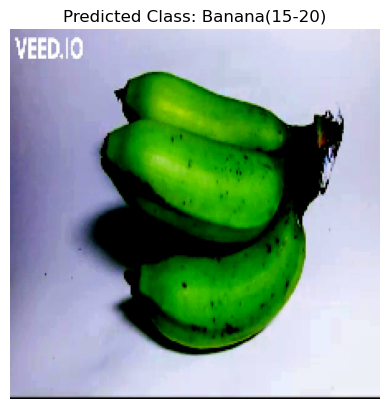

1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


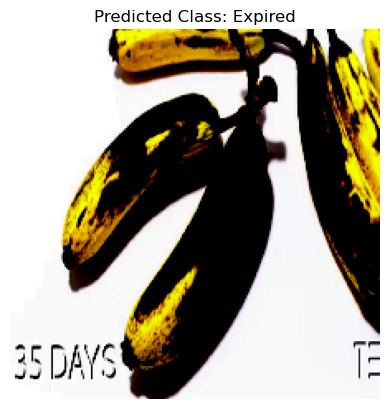

1/1 [==============================] - 0s 134ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


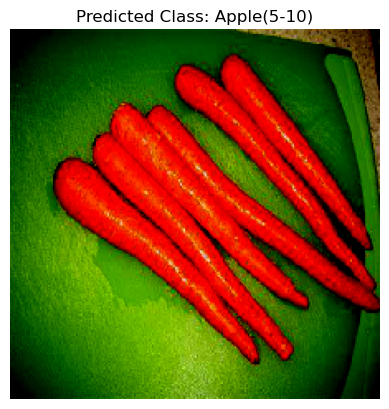

1/1 [==============================] - 0s 124ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


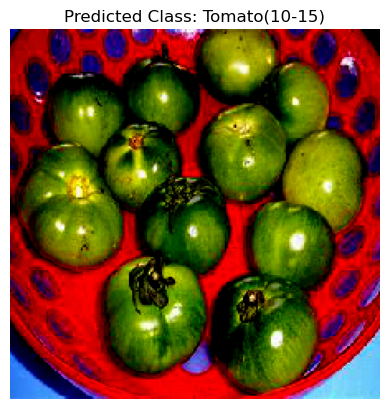

1/1 [==============================] - 0s 138ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


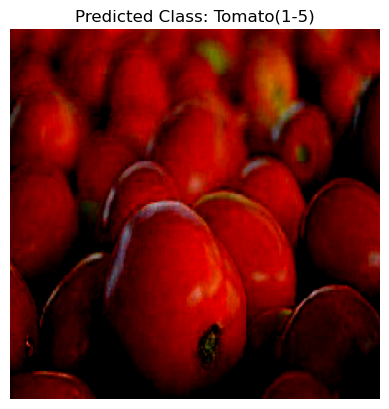

1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


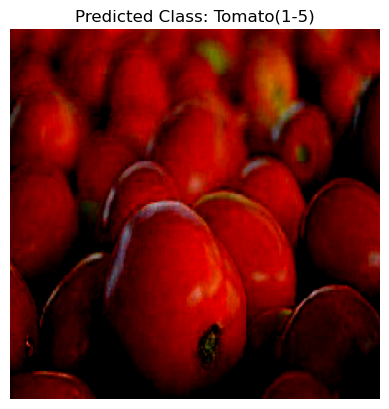

1/1 [==============================] - 0s 127ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


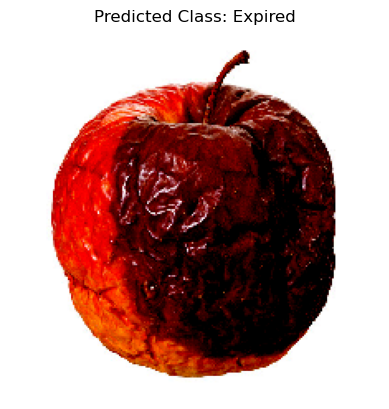

1/1 [==============================] - 0s 147ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


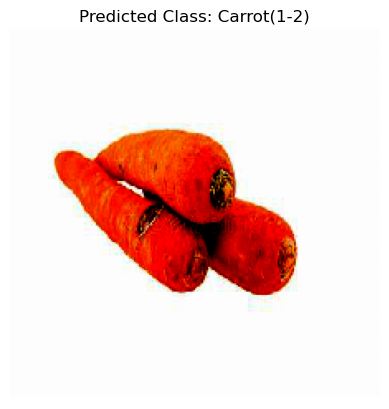

In [29]:
import matplotlib.pyplot as plt
# Define the path to the folder containing new images
new_images_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\new_test_images"

# Iterate through each image in the folder
for img_file in os.listdir(new_images_folder): 
    
    img_path = os.path.join(new_images_folder, img_file)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img_data = np.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img_data)
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Display the image and predicted class label
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_label}")
    plt.axis('off')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Define the path to the folder containing new images
new_images_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\banana_bunch_removed"

# Iterate through each image in the folder
for img_file in os.listdir(new_images_folder): 
    
    img_path = os.path.join(new_images_folder, img_file)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img_data = np.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img_data)
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Display the image and predicted class label
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_label}")
    plt.axis('off')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Define the path to the folder containing new images
new_images_folder = r"C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\new"

# Iterate through each image in the folder
for img_file in os.listdir(new_images_folder): 
    
    img_path = os.path.join(new_images_folder, img_file)
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img_data = np.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img_data)
    predicted_class = np.argmax(prediction)
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]

    # Display the image and predicted class label
    plt.imshow(img)
    plt.title(f"Predicted Class: {predicted_label}")
    plt.axis('off')
    plt.show()

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Define the path to the main folder containing the image subfolders
main_folder = r"C:/Users/RIYA DHAWAS/OneDrive/Desktop/Internship/archive (1)"


# Load the image data and labels
image_data = []
labels = []

# Iterate through each subfolder
for class_folder in os.listdir(main_folder):
    class_folder_path = os.path.join(main_folder, class_folder)
    if os.path.isdir(class_folder_path):
        # Load images from the subfolder
        for img_file in os.listdir(class_folder_path):
            img_path = os.path.join(class_folder_path, img_file)
            img = image.load_img(img_path, target_size=(224, 224))
            img = image.img_to_array(img)
            img = preprocess_input(img)
            image_data.append(img)
            labels.append(class_folder)

# Convert the image data and labels to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Perform one-hot encoding on the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels_encoded, test_size=0.2, random_state=42)

# Load the MobileNetV2 model (pre-trained on ImageNet)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a global average pooling layer and a fully connected layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
pip install --upgrade jupyter notebook


In [ ]:
pip install -U "jupyter-server<2.0.0"


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the folder containing class subdirectories
dataset_path = r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (4)\apple'

# Count the number of class subdirectories
num_classes = len([name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))])

input_shape = (224, 224, 3)  # Input shape expected by ResNet-50

# Load the ResNet-50 base model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [9]:
# Create an ImageDataGenerator for training data
train_data_generator = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)

# Train the model using ImageDataGenerator
model.fit(train_data_generator.flow_from_directory(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (4)\apple', target_size=(224, 224), batch_size=32), epochs=10)

# Save the trained model
model.save(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\various_models\apple.h5')


Found 858 images belonging to 4 classes.
Epoch 1/10
27/27 [==============================] - 245s 8s/step - loss: 1.1397 - accuracy: 0.5956
Epoch 2/10
27/27 [==============================] - 221s 8s/step - loss: 0.6773 - accuracy: 0.7214
Epoch 3/10
27/27 [==============================] - 216s 8s/step - loss: 0.5365 - accuracy: 0.7494
Epoch 4/10
27/27 [==============================] - 222s 8s/step - loss: 0.5410 - accuracy: 0.7506
Epoch 5/10
27/27 [==============================] - 219s 8s/step - loss: 0.4927 - accuracy: 0.7751
Epoch 6/10
27/27 [==============================] - 221s 8s/step - loss: 0.5147 - accuracy: 0.7716
Epoch 7/10
27/27 [==============================] - 229s 8s/step - loss: 0.3733 - accuracy: 0.8392
Epoch 8/10
27/27 [==============================] - 230s 8s/step - loss: 0.3838 - accuracy: 0.8531
Epoch 9/10
27/27 [==============================] - 233s 9s/step - loss: 0.4333 - accuracy: 0.8263
Epoch 10/10
27/27 [==============================] - 227s 8s/step - 

C:\Python3101\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the folder containing class subdirectories
dataset_path = r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (4)\banana'

# Count the number of class subdirectories
num_classes = len([name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))])

input_shape = (224, 224, 3)  # Input shape expected by ResNet-50

# Load the ResNet-50 base model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create an ImageDataGenerator for training data
train_data_generator = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)

# Train the model using ImageDataGenerator
model.fit(train_data_generator.flow_from_directory(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (4)\banana', target_size=(224, 224), batch_size=32), epochs=10)

# Save the trained model
model.save(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\various_models\banana.h5')


Found 512 images belonging to 5 classes.
Epoch 1/10
16/16 [==============================] - 151s 8s/step - loss: 1.1112 - accuracy: 0.6348
Epoch 2/10
16/16 [==============================] - 133s 8s/step - loss: 0.6999 - accuracy: 0.7539
Epoch 3/10
16/16 [==============================] - 133s 8s/step - loss: 0.5205 - accuracy: 0.8027
Epoch 4/10
16/16 [==============================] - 133s 8s/step - loss: 0.4744 - accuracy: 0.8066
Epoch 5/10
16/16 [==============================] - 133s 8s/step - loss: 0.4563 - accuracy: 0.8203
Epoch 6/10
16/16 [==============================] - 132s 8s/step - loss: 0.4052 - accuracy: 0.8301
Epoch 7/10
16/16 [==============================] - 132s 8s/step - loss: 0.3509 - accuracy: 0.8320
Epoch 8/10
16/16 [==============================] - 132s 8s/step - loss: 0.3144 - accuracy: 0.8594
Epoch 9/10
16/16 [==============================] - 133s 8s/step - loss: 0.3519 - accuracy: 0.8535
Epoch 10/10
16/16 [==============================] - 6949s 463s/step

In [12]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the folder containing class subdirectories
dataset_path = r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (4)\carrot'

# Count the number of class subdirectories
num_classes = len([name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))])

input_shape = (224, 224, 3)  # Input shape expected by ResNet-50

# Load the ResNet-50 base model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create an ImageDataGenerator for training data
train_data_generator = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)

# Train the model using ImageDataGenerator
model.fit(train_data_generator.flow_from_directory(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (4)\carrot', target_size=(224, 224), batch_size=32), epochs=10)

# Save the trained model
model.save(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\various_models\carrot.h5')


Found 206 images belonging to 4 classes.
Epoch 1/10
7/7 [==============================] - 79s 9s/step - loss: 1.6055 - accuracy: 0.5534
Epoch 2/10
7/7 [==============================] - 63s 9s/step - loss: 1.0028 - accuracy: 0.6262
Epoch 3/10
7/7 [==============================] - 69s 9s/step - loss: 0.7565 - accuracy: 0.6942
Epoch 4/10
7/7 [==============================] - 75s 12s/step - loss: 0.5968 - accuracy: 0.7427
Epoch 5/10
7/7 [==============================] - 79s 11s/step - loss: 0.4944 - accuracy: 0.7864
Epoch 6/10
7/7 [==============================] - 80s 11s/step - loss: 0.6458 - accuracy: 0.7573
Epoch 7/10
7/7 [==============================] - 80s 11s/step - loss: 0.5433 - accuracy: 0.7621
Epoch 8/10
7/7 [==============================] - 72s 10s/step - loss: 0.5364 - accuracy: 0.7621
Epoch 9/10
7/7 [==============================] - 74s 11s/step - loss: 0.4637 - accuracy: 0.8252
Epoch 10/10
7/7 [==============================] - 71s 10s/step - loss: 0.3342 - accuracy

In [13]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to the folder containing class subdirectories
dataset_path = r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (4)\tomato'

# Count the number of class subdirectories
num_classes = len([name for name in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, name))])

input_shape = (224, 224, 3)  # Input shape expected by ResNet-50

# Load the ResNet-50 base model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a global average pooling layer and a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create an ImageDataGenerator for training data
train_data_generator = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True  # Random horizontal flip
)

# Train the model using ImageDataGenerator
model.fit(train_data_generator.flow_from_directory(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\archive (4)\tomato', target_size=(224, 224), batch_size=32), epochs=10)

# Save the trained model
model.save(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\various_models\tomato.h5')


Found 407 images belonging to 4 classes.
Epoch 1/10
13/13 [==============================] - 181s 13s/step - loss: 1.7717 - accuracy: 0.4103
Epoch 2/10
13/13 [==============================] - 155s 12s/step - loss: 0.9890 - accuracy: 0.6265
Epoch 3/10
13/13 [==============================] - 156s 12s/step - loss: 0.8569 - accuracy: 0.6683
Epoch 4/10
13/13 [==============================] - 159s 13s/step - loss: 0.8785 - accuracy: 0.6585
Epoch 5/10
13/13 [==============================] - 153s 12s/step - loss: 0.6865 - accuracy: 0.6904
Epoch 6/10
13/13 [==============================] - 156s 12s/step - loss: 0.7310 - accuracy: 0.7322
Epoch 7/10
13/13 [==============================] - 157s 12s/step - loss: 0.6938 - accuracy: 0.7224
Epoch 8/10
13/13 [==============================] - 160s 12s/step - loss: 0.6047 - accuracy: 0.7420
Epoch 9/10
13/13 [==============================] - 169s 13s/step - loss: 0.5628 - accuracy: 0.7838
Epoch 10/10
13/13 [==============================] - 153s 1

1/1 [==============================] - 1s 1s/step


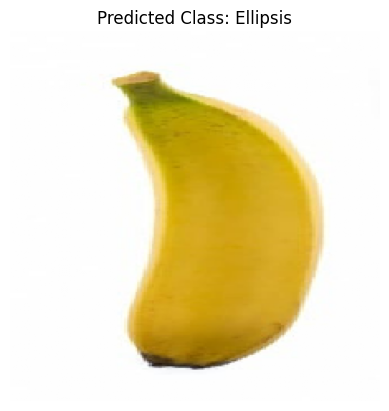

1/1 [==============================] - 0s 179ms/step


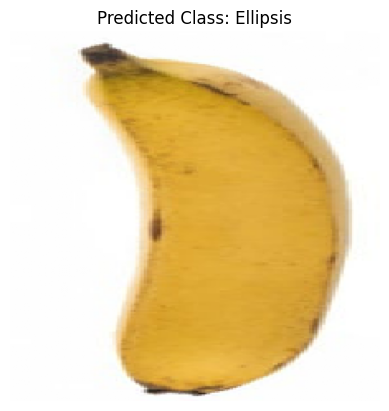

1/1 [==============================] - 0s 191ms/step


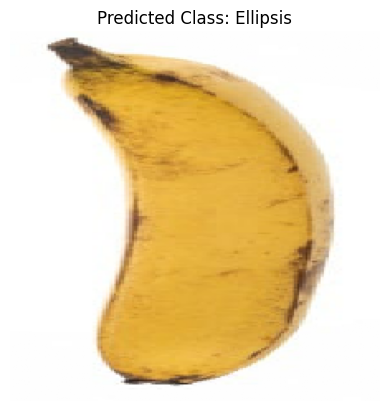

1/1 [==============================] - 0s 227ms/step


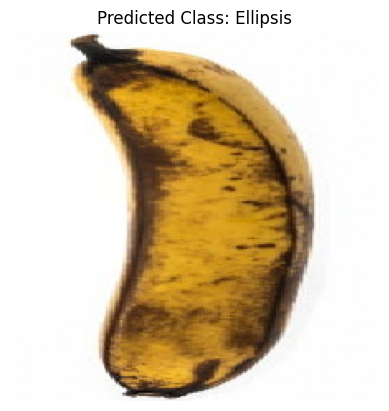

1/1 [==============================] - 0s 205ms/step


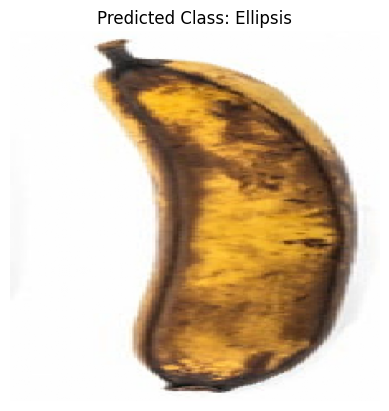

1/1 [==============================] - 0s 185ms/step


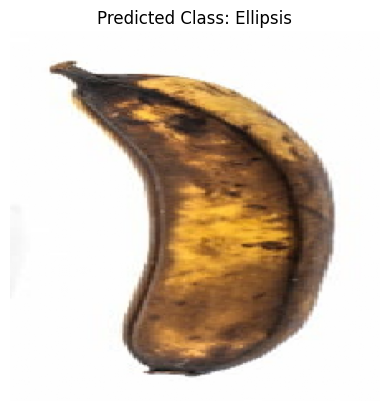

1/1 [==============================] - 0s 182ms/step


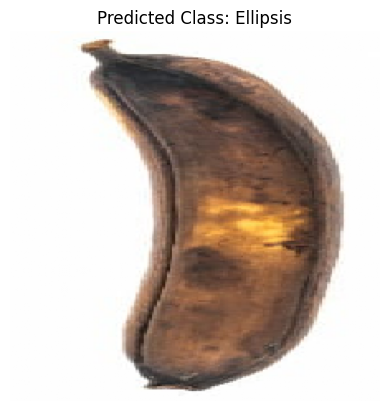

1/1 [==============================] - 0s 164ms/step


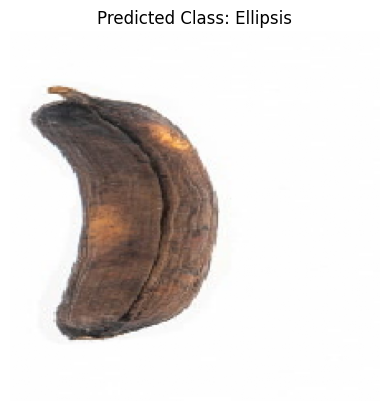

In [14]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained banana model
banana_model = load_model(r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\various_models\banana.h5')

# Path to the directory containing test images
test_images_directory = r'C:\Users\RIYA DHAWAS\OneDrive\Desktop\Internship\banana_home'  # Replace with the path to your test images directory

# Iterate through each image in the directory
for img_file in os.listdir(test_images_directory):
    img_path = os.path.join(test_images_directory, img_file)
    
    # Load and preprocess the test image
    test_image = image.load_img(img_path, target_size=(224, 224))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    
    # Make prediction
    prediction = banana_model.predict(test_image)
    
    # Get the class label with the highest probability
    class_index = np.argmax(prediction)
    class_label = ...  # Replace this with your label mapping or class names
    
    # Display the test image and predicted class
    plt.imshow(test_image[0] / 255.0)
    plt.title(f"Predicted Class: {class_label}")
    plt.axis('off')
    plt.show()
